In [1]:
import sys
import json
from datetime import time

import numpy as np
import pandas as pd
import awkward as ak
import uproot

import xgboost
from xgboost import XGBClassifier

# import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [2]:
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

def set_custom_alpha(col_, alpha_):
    rgb_ = to_rgba(col_)
    return (col_[0], col_[1], col_[2], alpha_)

def rgb2rgba(col_):
    _ = []
    for c in col_:
        _.append(float(c)/255.0)
    _.append(1.0)
    return tuple(_)

def getNcols(N=3, cmap_='plasma'):
    cmap = plt.get_cmap(cmap_)
    cols = cmap.colors
    arr = []
    for i in range(N):
        arr.append(cols[int(256*float(i)/float(N))])
    return arr

In [3]:
def get_arrays(tree, branch_list):
    _dict = {}
    for _br in branch_list:
        _dict[_br] = getattr(tree[_br].arrays(), _br)
    return pd.DataFrame.from_dict(_dict)

def get_input_features(df, train_list, cuts=''):
    if cuts=='': return df[train_list].to_numpy()
    _df = df[df.eval(cuts)]
    return _df[train_list].to_numpy()

In [4]:
def compute_amssig(s_, b_):
    if b_==0.0: return 0.0
    return np.sqrt(2*((s_+b_)*np.log(1+s_/b_)-s_))

def compute_sig(s_, b_):
    if b_==0.0: return 0.0
    return np.sqrt(s_/b_)

def generate_mesh(d=2, nbins=40):
    minbin = int(nbins/2)
    grid = [ [a] for a in np.linspace(minbin, nbins-1, nbins-minbin) ]
    for i in range(d-1):
        tmpgrid = []
        for pt in grid:
            for e in np.linspace(0, nbins-1, nbins):
                if e>=pt[-1]:
                    continue
                else:
                    tmppt = [ p_ for p_ in pt ]
                    tmppt.append(e)
                    tmpgrid.append(tmppt)
        grid = tmpgrid
    return grid

def get_stepped_plot(xarray, yarray):
    
    xsize = len(xarray)
    ysize = len(yarray)
    
    X = (xarray.reshape(xsize, 1)*np.ones(2)).flatten()[1:]
    Y = (yarray.reshape(ysize, 1)*np.ones(2)).flatten()[0:-1]
    
    return X, Y

def get_optimal_significance_cuts(hist_array, ncuts=2):
    significances = []
    optimal_cuts = []
    nbins = len(hist_array[1])-1
    meshgrid = generate_mesh(ncuts, nbins)
    for pt in meshgrid:
        tmp = []
        for icut, cut in enumerate(pt):
            if icut==0:
                int_sig = np.sum(hist_array[0][0][int(cut):])
                int_bkg = np.sum(hist_array[0][1][int(cut):])
            else:
                int_sig = np.sum(hist_array[0][0][int(cut):int(pt[icut-1])])
                int_bkg = np.sum(hist_array[0][1][int(cut):int(pt[icut-1])])
            tmp.append(compute_sig(int_sig, int_bkg))
        
        # get quadrature sum of significances
        sig = 0
        for s in tmp:
            sig += s**2
        significances.append(np.sqrt(sig))
    
    optidx = significances.index(max(significances))
    for c in meshgrid[optidx]:
        optimal_cuts.append(hist_array[1][int(c)])
    return significances[optidx], significances, meshgrid, optimal_cuts

In [86]:
training_variables = ['var_vertexKFChi2', 'var_svpvTauAngle', 'var_flightLenSig', 'var_pmin', 'var_max_cLP', 'var_max_tKink', 'var_MinD0Significance', 'var_mindca_iso', 'var_trk_relPt', 'min(Muon1_segmentCompatibility, Muon2_segmentCompatibility)', 'var_globalMuon1Id', 'var_globalMuon2Id', 'var_trackerMuonId_without_calo','var_NtracksClose', 'muon3_seg_comp_dnn', 'Muon1_BSdxySig', 'Muon2_BSdxySig', 'Muon3_BSdxySig']
spectator_variables = ['run', 'lumi', 'eventNumber', 'var_tauMassRefitted', 'category', 'threeGlobal', 'bdt_weight', 'eventWeight']

In [30]:
filename = '../../Preapproval/Ntuples/2018/T3MSelectionTreeInput_preapproval_v1_combined_2018UL_calo_check_muonsf.root'

In [87]:
# load data
input_file = uproot.open(filename)
bkg_tree = get_arrays(input_file['TreeB'], training_variables+spectator_variables)
ds_tree = get_arrays(input_file['TreeS_Ds'], training_variables+spectator_variables)
bu_tree = get_arrays(input_file['TreeS_Bu'], training_variables+spectator_variables)
bd_tree = get_arrays(input_file['TreeS_Bd'], training_variables+spectator_variables)

In [16]:
# category A
bkg_trainX_categoryA = get_input_features(bkg_tree, training_variables,
                   'category==1 & (var_tauMassRefitted > 1.825 | var_tauMassRefitted < 1.729) & threeGlobal==0')
ds_trainX_categoryA = get_input_features(ds_tree, training_variables, 'category==1 & threeGlobal==0')
bu_trainX_categoryA = get_input_features(bu_tree, training_variables, 'category==1 & threeGlobal==0')
bd_trainX_categoryA = get_input_features(bd_tree, training_variables, 'category==1 & threeGlobal==0')

bkg_eventNumber_categoryA = get_input_features(bkg_tree, ['eventNumber'],
                   'category==1 & (var_tauMassRefitted > 1.825 | var_tauMassRefitted < 1.729) & threeGlobal==0')
ds_eventNumber_categoryA = get_input_features(ds_tree, ['eventNumber'], 'category==1 & threeGlobal==0')
bu_eventNumber_categoryA = get_input_features(bu_tree, ['eventNumber'], 'category==1 & threeGlobal==0')
bd_eventNumber_categoryA = get_input_features(bd_tree, ['eventNumber'], 'category==1 & threeGlobal==0')

bkg_trainY_categoryA = np.zeros(len(bkg_trainX_categoryA))
ds_trainY_categoryA = np.ones(len(ds_trainX_categoryA))
bu_trainY_categoryA = np.ones(len(bu_trainX_categoryA))
bd_trainY_categoryA = np.ones(len(bd_trainX_categoryA))

bkg_weights_categoryA = np.ones(len(bkg_trainX_categoryA))
ds_weights_categoryA = ds_trainY_categoryA*0.72
bu_weights_categoryA = bu_trainY_categoryA*0.14
bd_weights_categoryA = bd_trainY_categoryA*0.14

# split data into X and y
X_categoryA = np.concatenate((bkg_trainX_categoryA, ds_trainX_categoryA, bu_trainX_categoryA, bd_trainX_categoryA))
Y_categoryA = np.concatenate((bkg_trainY_categoryA, ds_trainY_categoryA, bu_trainY_categoryA, bd_trainY_categoryA))
weight_categoryA = np.concatenate((bkg_weights_categoryA, ds_weights_categoryA, bu_weights_categoryA ,bd_weights_categoryA))

In [17]:
# category B
bkg_trainX_categoryB = get_input_features(bkg_tree, training_variables,
                   'category==2 & (var_tauMassRefitted > 1.853 | var_tauMassRefitted < 1.701) & threeGlobal==0')
ds_trainX_categoryB = get_input_features(ds_tree, training_variables, 'category==2 & threeGlobal==0')
bu_trainX_categoryB = get_input_features(bu_tree, training_variables, 'category==2 & threeGlobal==0')
bd_trainX_categoryB = get_input_features(bd_tree, training_variables, 'category==2 & threeGlobal==0')

bkg_eventNumber_categoryB = get_input_features(bkg_tree, ['eventNumber'],
                   'category==2 & (var_tauMassRefitted > 1.853 | var_tauMassRefitted < 1.701) & threeGlobal==0')
ds_eventNumber_categoryB = get_input_features(ds_tree, ['eventNumber'], 'category==2 & threeGlobal==0')
bu_eventNumber_categoryB = get_input_features(bu_tree, ['eventNumber'], 'category==2 & threeGlobal==0')
bd_eventNumber_categoryB = get_input_features(bd_tree, ['eventNumber'], 'category==2 & threeGlobal==0')

bkg_trainY_categoryB = np.zeros(len(bkg_trainX_categoryB))
ds_trainY_categoryB = np.ones(len(ds_trainX_categoryB))
bu_trainY_categoryB = np.ones(len(bu_trainX_categoryB))
bd_trainY_categoryB = np.ones(len(bd_trainX_categoryB))

bkg_weights_categoryB = np.ones(len(bkg_trainX_categoryB))
ds_weights_categoryB = ds_trainY_categoryB*0.72
bu_weights_categoryB = bu_trainY_categoryB*0.14
bd_weights_categoryB = bd_trainY_categoryB*0.14

# split data into X and y
X_categoryB = np.concatenate((bkg_trainX_categoryB, ds_trainX_categoryB, bu_trainX_categoryB, bd_trainX_categoryB))
Y_categoryB = np.concatenate((bkg_trainY_categoryB, ds_trainY_categoryB, bu_trainY_categoryB, bd_trainY_categoryB))
weight_categoryB = np.concatenate((bkg_weights_categoryB, ds_weights_categoryB, bu_weights_categoryB ,bd_weights_categoryB))

In [18]:
# category C
bkg_trainX_categoryC = get_input_features(bkg_tree, training_variables,
                   'category==3 & (var_tauMassRefitted<1.677 | var_tauMassRefitted>1.877) & threeGlobal==0')
ds_trainX_categoryC = get_input_features(ds_tree, training_variables, 'category==3 & threeGlobal==0')
bu_trainX_categoryC = get_input_features(bu_tree, training_variables, 'category==3 & threeGlobal==0')
bd_trainX_categoryC = get_input_features(bd_tree, training_variables, 'category==3 & threeGlobal==0')

bkg_eventNumber_categoryC = get_input_features(bkg_tree, ['eventNumber'],
                   'category==3 & (var_tauMassRefitted<1.677 | var_tauMassRefitted>1.877) & threeGlobal==0')
ds_eventNumber_categoryC = get_input_features(ds_tree, ['eventNumber'], 'category==3 & threeGlobal==0')
bu_eventNumber_categoryC = get_input_features(bu_tree, ['eventNumber'], 'category==3 & threeGlobal==0')
bd_eventNumber_categoryC = get_input_features(bd_tree, ['eventNumber'], 'category==3 & threeGlobal==0')

bkg_trainY_categoryC = np.zeros(len(bkg_trainX_categoryC))
ds_trainY_categoryC = np.ones(len(ds_trainX_categoryC))
bu_trainY_categoryC = np.ones(len(bu_trainX_categoryC))
bd_trainY_categoryC = np.ones(len(bd_trainX_categoryC))

bkg_weights_categoryC = np.ones(len(bkg_trainX_categoryC))
ds_weights_categoryC = ds_trainY_categoryC*0.72
bu_weights_categoryC = bu_trainY_categoryC*0.14
bd_weights_categoryC = bd_trainY_categoryC*0.14

# split data into X and y
X_categoryC = np.concatenate((bkg_trainX_categoryC, ds_trainX_categoryC, bu_trainX_categoryC, bd_trainX_categoryC))
Y_categoryC = np.concatenate((bkg_trainY_categoryC, ds_trainY_categoryC, bu_trainY_categoryC, bd_trainY_categoryC))
weight_categoryC = np.concatenate((bkg_weights_categoryC, ds_weights_categoryC, bu_weights_categoryC ,bd_weights_categoryC))

In [15]:
kFolds = 5
kfold_split_by_event_categoryA = np.concatenate((bkg_eventNumber_categoryA % kFolds,
                                       ds_eventNumber_categoryA % kFolds,
                                       bu_eventNumber_categoryA % kFolds,
                                       bd_eventNumber_categoryA % kFolds))
kfold_split_by_event_categoryB = np.concatenate((bkg_eventNumber_categoryB % kFolds,
                                       ds_eventNumber_categoryB % kFolds,
                                       bu_eventNumber_categoryB % kFolds,
                                       bd_eventNumber_categoryB % kFolds))
kfold_split_by_event_categoryC = np.concatenate((bkg_eventNumber_categoryC % kFolds,
                                       ds_eventNumber_categoryC % kFolds,
                                       bu_eventNumber_categoryC % kFolds,
                                       bd_eventNumber_categoryC % kFolds))

[0]	validation_0-error:0.20030	validation_1-error:0.20395
[1]	validation_0-error:0.19070	validation_1-error:0.19163
[2]	validation_0-error:0.19060	validation_1-error:0.19199
[3]	validation_0-error:0.19045	validation_1-error:0.19175
[4]	validation_0-error:0.18945	validation_1-error:0.18980
[5]	validation_0-error:0.17175	validation_1-error:0.17112
[6]	validation_0-error:0.17549	validation_1-error:0.17369
[7]	validation_0-error:0.17030	validation_1-error:0.16868
[8]	validation_0-error:0.17051	validation_1-error:0.16941
[9]	validation_0-error:0.17419	validation_1-error:0.17173
[10]	validation_0-error:0.16546	validation_1-error:0.16490
[11]	validation_0-error:0.16424	validation_1-error:0.16319
[12]	validation_0-error:0.16178	validation_1-error:0.16099
[13]	validation_0-error:0.16193	validation_1-error:0.16050
[14]	validation_0-error:0.16169	validation_1-error:0.15977
[15]	validation_0-error:0.16367	validation_1-error:0.16282
[16]	validation_0-error:0.16093	validation_1-error:0.16111
[17]	va

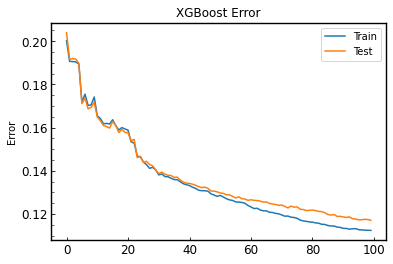

In [38]:
X_train = X_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold,:]
Y_train = Y_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
weights_train_categoryA = weight_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]

X_test = X_categoryA[kfold_split_by_event_categoryA.flatten()==ifold,:]
Y_test = Y_categoryA[kfold_split_by_event_categoryA.flatten()==ifold]

model = xgboost.XGBRegressor(objective='binary:logistic',
                             learning_rate=0.08,
                             max_depth=3, n_estimators=100)
history = model.fit(X_train, Y_train,
                    eval_set=[(X_train, Y_train), (X_test, Y_test)],
                    eval_metric="error", sample_weight=weights_train_categoryA)
results =  model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

[0]	validation_0-error:0.20030	validation_1-error:0.20395
[1]	validation_0-error:0.19070	validation_1-error:0.19163
[2]	validation_0-error:0.19063	validation_1-error:0.19199
[3]	validation_0-error:0.19085	validation_1-error:0.19187
[4]	validation_0-error:0.19063	validation_1-error:0.19199
[5]	validation_0-error:0.18607	validation_1-error:0.18687
[6]	validation_0-error:0.18735	validation_1-error:0.18772
[7]	validation_0-error:0.18723	validation_1-error:0.18735
[8]	validation_0-error:0.17513	validation_1-error:0.17491
[9]	validation_0-error:0.17510	validation_1-error:0.17478
[10]	validation_0-error:0.17492	validation_1-error:0.17466
[11]	validation_0-error:0.17495	validation_1-error:0.17466
[12]	validation_0-error:0.17461	validation_1-error:0.17430
[13]	validation_0-error:0.17446	validation_1-error:0.17417
[14]	validation_0-error:0.17437	validation_1-error:0.17393
[15]	validation_0-error:0.16996	validation_1-error:0.17039
[16]	validation_0-error:0.16923	validation_1-error:0.16929
[17]	va

[139]	validation_0-error:0.11441	validation_1-error:0.11913
[140]	validation_0-error:0.11411	validation_1-error:0.11888
[141]	validation_0-error:0.11389	validation_1-error:0.11864
[142]	validation_0-error:0.11365	validation_1-error:0.11803
[143]	validation_0-error:0.11380	validation_1-error:0.11852
[144]	validation_0-error:0.11326	validation_1-error:0.11803
[145]	validation_0-error:0.11320	validation_1-error:0.11778
[146]	validation_0-error:0.11298	validation_1-error:0.11791
[147]	validation_0-error:0.11298	validation_1-error:0.11803
[148]	validation_0-error:0.11317	validation_1-error:0.11803
[149]	validation_0-error:0.11277	validation_1-error:0.11778
[150]	validation_0-error:0.11253	validation_1-error:0.11778
[151]	validation_0-error:0.11259	validation_1-error:0.11754
[152]	validation_0-error:0.11250	validation_1-error:0.11778
[153]	validation_0-error:0.11207	validation_1-error:0.11705
[154]	validation_0-error:0.11198	validation_1-error:0.11717
[155]	validation_0-error:0.11189	validat

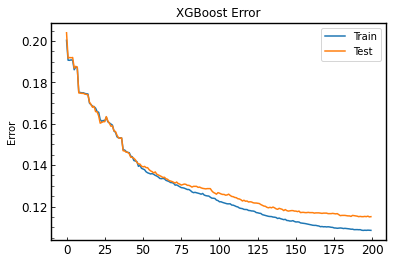

In [40]:
X_train = X_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold,:]
Y_train = Y_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
weights_train_categoryA = weight_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]

X_test = X_categoryA[kfold_split_by_event_categoryA.flatten()==ifold,:]
Y_test = Y_categoryA[kfold_split_by_event_categoryA.flatten()==ifold]

model = xgboost.XGBRegressor(objective='binary:logistic',
                             learning_rate=0.05,
                             max_depth=3, n_estimators=200)
history = model.fit(X_train, Y_train,
                    eval_set=[(X_train, Y_train), (X_test, Y_test)],
                    eval_metric="error", sample_weight=weights_train_categoryA)
results =  model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

In [19]:
xgbcvclassifiers = {'categoryA':[],
                    'categoryB':[],
                    'categoryC':[]}

In [24]:
# fit models (category A)
for ifold in range(kFolds):
    X_train = X_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold,:]
    Y_train = Y_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
    weights_train_categoryA = weight_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
    
    X_test = X_categoryA[kfold_split_by_event_categoryA.flatten()==ifold,:]
    Y_test = Y_categoryA[kfold_split_by_event_categoryA.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.08,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryA)
    xgbcvclassifiers['categoryA'].append((model, history))

[0]	validation_0-error:0.19159	validation_1-error:0.18870
[1]	validation_0-error:0.18658	validation_1-error:0.18449
[2]	validation_0-error:0.18689	validation_1-error:0.18437
[3]	validation_0-error:0.18661	validation_1-error:0.18485
[4]	validation_0-error:0.18671	validation_1-error:0.18461
[5]	validation_0-error:0.17169	validation_1-error:0.17172
[6]	validation_0-error:0.18655	validation_1-error:0.18461
[7]	validation_0-error:0.17169	validation_1-error:0.17172
[8]	validation_0-error:0.17130	validation_1-error:0.17160
[9]	validation_0-error:0.17124	validation_1-error:0.17148
[10]	validation_0-error:0.17566	validation_1-error:0.17449
[11]	validation_0-error:0.17108	validation_1-error:0.17136
[12]	validation_0-error:0.17026	validation_1-error:0.17040
[13]	validation_0-error:0.17081	validation_1-error:0.17112
[14]	validation_0-error:0.17032	validation_1-error:0.17028
[15]	validation_0-error:0.17108	validation_1-error:0.17052
[16]	validation_0-error:0.16568	validation_1-error:0.16510
[17]	va

[40]	validation_0-error:0.14320	validation_1-error:0.14500
[41]	validation_0-error:0.14298	validation_1-error:0.14488
[42]	validation_0-error:0.14283	validation_1-error:0.14524
[43]	validation_0-error:0.14237	validation_1-error:0.14452
[44]	validation_0-error:0.14240	validation_1-error:0.14440
[45]	validation_0-error:0.14195	validation_1-error:0.14368
[46]	validation_0-error:0.14213	validation_1-error:0.14368
[47]	validation_0-error:0.14182	validation_1-error:0.14356
[48]	validation_0-error:0.13999	validation_1-error:0.14344
[49]	validation_0-error:0.14048	validation_1-error:0.14272
[50]	validation_0-error:0.14094	validation_1-error:0.14296
[51]	validation_0-error:0.14002	validation_1-error:0.14260
[52]	validation_0-error:0.13981	validation_1-error:0.14272
[53]	validation_0-error:0.13685	validation_1-error:0.13948
[54]	validation_0-error:0.13639	validation_1-error:0.13888
[55]	validation_0-error:0.13670	validation_1-error:0.13924
[56]	validation_0-error:0.13563	validation_1-error:0.138

[80]	validation_0-error:0.12741	validation_1-error:0.13068
[81]	validation_0-error:0.12747	validation_1-error:0.13044
[82]	validation_0-error:0.12726	validation_1-error:0.13044
[83]	validation_0-error:0.12680	validation_1-error:0.13068
[84]	validation_0-error:0.12656	validation_1-error:0.13044
[85]	validation_0-error:0.12637	validation_1-error:0.13056
[86]	validation_0-error:0.12625	validation_1-error:0.13020
[87]	validation_0-error:0.12583	validation_1-error:0.13007
[88]	validation_0-error:0.12580	validation_1-error:0.12995
[89]	validation_0-error:0.12580	validation_1-error:0.12958
[90]	validation_0-error:0.12546	validation_1-error:0.12921
[91]	validation_0-error:0.12513	validation_1-error:0.12885
[92]	validation_0-error:0.12495	validation_1-error:0.12872
[93]	validation_0-error:0.12449	validation_1-error:0.12885
[94]	validation_0-error:0.12428	validation_1-error:0.12897
[95]	validation_0-error:0.12404	validation_1-error:0.12860
[96]	validation_0-error:0.12394	validation_1-error:0.128

[20]	validation_0-error:0.16583	validation_1-error:0.16575
[21]	validation_0-error:0.16555	validation_1-error:0.16380
[22]	validation_0-error:0.16200	validation_1-error:0.16026
[23]	validation_0-error:0.16117	validation_1-error:0.16062
[24]	validation_0-error:0.16157	validation_1-error:0.16099
[25]	validation_0-error:0.16145	validation_1-error:0.16099
[26]	validation_0-error:0.16318	validation_1-error:0.16343
[27]	validation_0-error:0.16093	validation_1-error:0.16136
[28]	validation_0-error:0.16038	validation_1-error:0.16026
[29]	validation_0-error:0.15978	validation_1-error:0.15879
[30]	validation_0-error:0.15932	validation_1-error:0.15892
[31]	validation_0-error:0.15649	validation_1-error:0.15660
[32]	validation_0-error:0.15585	validation_1-error:0.15623
[33]	validation_0-error:0.15366	validation_1-error:0.15440
[34]	validation_0-error:0.15315	validation_1-error:0.15318
[35]	validation_0-error:0.15318	validation_1-error:0.15293
[36]	validation_0-error:0.15309	validation_1-error:0.153

In [25]:
# fit models (category B)
for ifold in range(kFolds):
    X_train = X_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold,:]
    Y_train = Y_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold]
    weights_train_categoryB = weight_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold]
    
    X_test = X_categoryB[kfold_split_by_event_categoryB.flatten()==ifold,:]
    Y_test = Y_categoryB[kfold_split_by_event_categoryB.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.1,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryB)
    xgbcvclassifiers['categoryB'].append((model, history))

[0]	validation_0-error:0.23154	validation_1-error:0.23102
[1]	validation_0-error:0.22565	validation_1-error:0.22666
[2]	validation_0-error:0.21726	validation_1-error:0.21714
[3]	validation_0-error:0.20315	validation_1-error:0.20259
[4]	validation_0-error:0.20220	validation_1-error:0.20210
[5]	validation_0-error:0.20213	validation_1-error:0.20210
[6]	validation_0-error:0.19734	validation_1-error:0.19841
[7]	validation_0-error:0.19748	validation_1-error:0.19826
[8]	validation_0-error:0.19696	validation_1-error:0.19773
[9]	validation_0-error:0.19530	validation_1-error:0.19724
[10]	validation_0-error:0.19624	validation_1-error:0.19817
[11]	validation_0-error:0.19655	validation_1-error:0.19750
[12]	validation_0-error:0.19547	validation_1-error:0.19700
[13]	validation_0-error:0.19145	validation_1-error:0.19337
[14]	validation_0-error:0.19041	validation_1-error:0.19176
[15]	validation_0-error:0.19015	validation_1-error:0.19082
[16]	validation_0-error:0.19071	validation_1-error:0.19173
[17]	va

[40]	validation_0-error:0.16749	validation_1-error:0.17201
[41]	validation_0-error:0.16720	validation_1-error:0.17148
[42]	validation_0-error:0.16654	validation_1-error:0.17134
[43]	validation_0-error:0.16549	validation_1-error:0.17038
[44]	validation_0-error:0.16565	validation_1-error:0.17026
[45]	validation_0-error:0.16510	validation_1-error:0.16997
[46]	validation_0-error:0.16496	validation_1-error:0.16997
[47]	validation_0-error:0.16510	validation_1-error:0.17012
[48]	validation_0-error:0.16469	validation_1-error:0.16977
[49]	validation_0-error:0.16495	validation_1-error:0.16948
[50]	validation_0-error:0.16480	validation_1-error:0.16928
[51]	validation_0-error:0.16453	validation_1-error:0.16925
[52]	validation_0-error:0.16416	validation_1-error:0.16876
[53]	validation_0-error:0.16360	validation_1-error:0.16809
[54]	validation_0-error:0.16335	validation_1-error:0.16803
[55]	validation_0-error:0.16307	validation_1-error:0.16783
[56]	validation_0-error:0.16241	validation_1-error:0.167

[80]	validation_0-error:0.15419	validation_1-error:0.15316
[81]	validation_0-error:0.15366	validation_1-error:0.15272
[82]	validation_0-error:0.15334	validation_1-error:0.15217
[83]	validation_0-error:0.15335	validation_1-error:0.15214
[84]	validation_0-error:0.15308	validation_1-error:0.15208
[85]	validation_0-error:0.15283	validation_1-error:0.15159
[86]	validation_0-error:0.15239	validation_1-error:0.15124
[87]	validation_0-error:0.15191	validation_1-error:0.15101
[88]	validation_0-error:0.15177	validation_1-error:0.15043
[89]	validation_0-error:0.15135	validation_1-error:0.15025
[90]	validation_0-error:0.15115	validation_1-error:0.15034
[91]	validation_0-error:0.15100	validation_1-error:0.15017
[92]	validation_0-error:0.15077	validation_1-error:0.14994
[93]	validation_0-error:0.15040	validation_1-error:0.14950
[94]	validation_0-error:0.15016	validation_1-error:0.14927
[95]	validation_0-error:0.14977	validation_1-error:0.14892
[96]	validation_0-error:0.14964	validation_1-error:0.148

[20]	validation_0-error:0.18513	validation_1-error:0.18686
[21]	validation_0-error:0.18461	validation_1-error:0.18634
[22]	validation_0-error:0.18454	validation_1-error:0.18640
[23]	validation_0-error:0.18357	validation_1-error:0.18532
[24]	validation_0-error:0.18309	validation_1-error:0.18529
[25]	validation_0-error:0.18141	validation_1-error:0.18309
[26]	validation_0-error:0.17886	validation_1-error:0.17999
[27]	validation_0-error:0.17862	validation_1-error:0.17981
[28]	validation_0-error:0.17832	validation_1-error:0.17941
[29]	validation_0-error:0.17560	validation_1-error:0.17752
[30]	validation_0-error:0.17605	validation_1-error:0.17761
[31]	validation_0-error:0.17377	validation_1-error:0.17546
[32]	validation_0-error:0.17322	validation_1-error:0.17479
[33]	validation_0-error:0.17266	validation_1-error:0.17418
[34]	validation_0-error:0.17178	validation_1-error:0.17366
[35]	validation_0-error:0.17118	validation_1-error:0.17288
[36]	validation_0-error:0.17037	validation_1-error:0.171

In [26]:
# fit models (category C)
for ifold in range(kFolds):
    X_train = X_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold,:]
    Y_train = Y_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold]
    weights_train_categoryC = weight_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold]
    
    X_test = X_categoryC[kfold_split_by_event_categoryC.flatten()==ifold,:]
    Y_test = Y_categoryC[kfold_split_by_event_categoryC.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.05,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryC)
    xgbcvclassifiers['categoryC'].append((model, history))

[0]	validation_0-error:0.14397	validation_1-error:0.14302
[1]	validation_0-error:0.14386	validation_1-error:0.14294
[2]	validation_0-error:0.14399	validation_1-error:0.14306
[3]	validation_0-error:0.14358	validation_1-error:0.14286
[4]	validation_0-error:0.14358	validation_1-error:0.14282
[5]	validation_0-error:0.14356	validation_1-error:0.14266
[6]	validation_0-error:0.14346	validation_1-error:0.14262
[7]	validation_0-error:0.14331	validation_1-error:0.14234
[8]	validation_0-error:0.13991	validation_1-error:0.13917
[9]	validation_0-error:0.13970	validation_1-error:0.13893
[10]	validation_0-error:0.13978	validation_1-error:0.13901
[11]	validation_0-error:0.13771	validation_1-error:0.13657
[12]	validation_0-error:0.13662	validation_1-error:0.13520
[13]	validation_0-error:0.13511	validation_1-error:0.13436
[14]	validation_0-error:0.13464	validation_1-error:0.13364
[15]	validation_0-error:0.13473	validation_1-error:0.13340
[16]	validation_0-error:0.13438	validation_1-error:0.13352
[17]	va

[40]	validation_0-error:0.12566	validation_1-error:0.12812
[41]	validation_0-error:0.12510	validation_1-error:0.12812
[42]	validation_0-error:0.12483	validation_1-error:0.12749
[43]	validation_0-error:0.12448	validation_1-error:0.12738
[44]	validation_0-error:0.12438	validation_1-error:0.12690
[45]	validation_0-error:0.12440	validation_1-error:0.12679
[46]	validation_0-error:0.12407	validation_1-error:0.12667
[47]	validation_0-error:0.12343	validation_1-error:0.12643
[48]	validation_0-error:0.12312	validation_1-error:0.12620
[49]	validation_0-error:0.12271	validation_1-error:0.12513
[50]	validation_0-error:0.12221	validation_1-error:0.12458
[51]	validation_0-error:0.12203	validation_1-error:0.12427
[52]	validation_0-error:0.12176	validation_1-error:0.12411
[53]	validation_0-error:0.12140	validation_1-error:0.12376
[54]	validation_0-error:0.12129	validation_1-error:0.12356
[55]	validation_0-error:0.12109	validation_1-error:0.12312
[56]	validation_0-error:0.12066	validation_1-error:0.122

[80]	validation_0-error:0.11442	validation_1-error:0.11549
[81]	validation_0-error:0.11439	validation_1-error:0.11541
[82]	validation_0-error:0.11429	validation_1-error:0.11533
[83]	validation_0-error:0.11406	validation_1-error:0.11470
[84]	validation_0-error:0.11364	validation_1-error:0.11434
[85]	validation_0-error:0.11339	validation_1-error:0.11411
[86]	validation_0-error:0.11314	validation_1-error:0.11411
[87]	validation_0-error:0.11300	validation_1-error:0.11411
[88]	validation_0-error:0.11282	validation_1-error:0.11383
[89]	validation_0-error:0.11254	validation_1-error:0.11395
[90]	validation_0-error:0.11220	validation_1-error:0.11351
[91]	validation_0-error:0.11177	validation_1-error:0.11335
[92]	validation_0-error:0.11166	validation_1-error:0.11312
[93]	validation_0-error:0.11138	validation_1-error:0.11288
[94]	validation_0-error:0.11121	validation_1-error:0.11304
[95]	validation_0-error:0.11107	validation_1-error:0.11272
[96]	validation_0-error:0.11081	validation_1-error:0.112

[20]	validation_0-error:0.13140	validation_1-error:0.13286
[21]	validation_0-error:0.13094	validation_1-error:0.13262
[22]	validation_0-error:0.13012	validation_1-error:0.13186
[23]	validation_0-error:0.12951	validation_1-error:0.13117
[24]	validation_0-error:0.12952	validation_1-error:0.13101
[25]	validation_0-error:0.12959	validation_1-error:0.13153
[26]	validation_0-error:0.12912	validation_1-error:0.13069
[27]	validation_0-error:0.12891	validation_1-error:0.13093
[28]	validation_0-error:0.12854	validation_1-error:0.13008
[29]	validation_0-error:0.12758	validation_1-error:0.12891
[30]	validation_0-error:0.12782	validation_1-error:0.12940
[31]	validation_0-error:0.12715	validation_1-error:0.12887
[32]	validation_0-error:0.12749	validation_1-error:0.12883
[33]	validation_0-error:0.12713	validation_1-error:0.12887
[34]	validation_0-error:0.12680	validation_1-error:0.12875
[35]	validation_0-error:0.12663	validation_1-error:0.12847
[36]	validation_0-error:0.12655	validation_1-error:0.128

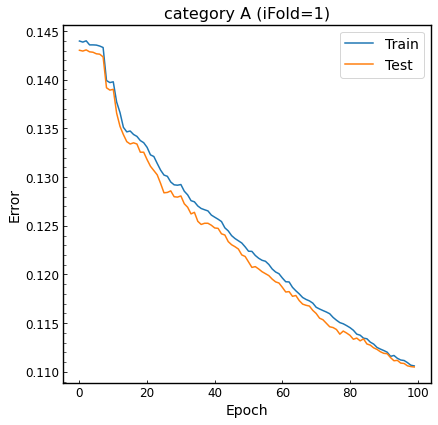

In [49]:
results =  xgbcvclassifiers['categoryC'][0][0].evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(6.6,6.6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend(fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.title('category A (iFold={})'.format(1), fontsize=16)
plt.show()

In [50]:
def plot_training_history(model, category, fold):    
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6.6,6.6))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend(fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.title('category {} (iFold={})'.format(category, fold), fontsize=16)
    plt.show()

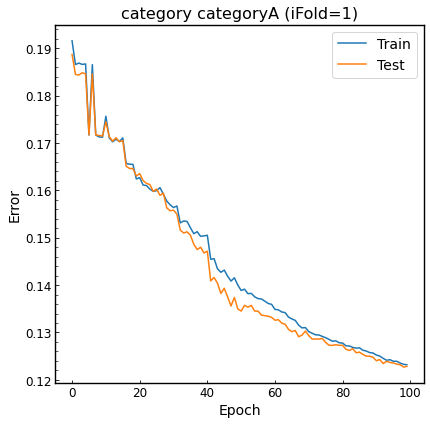

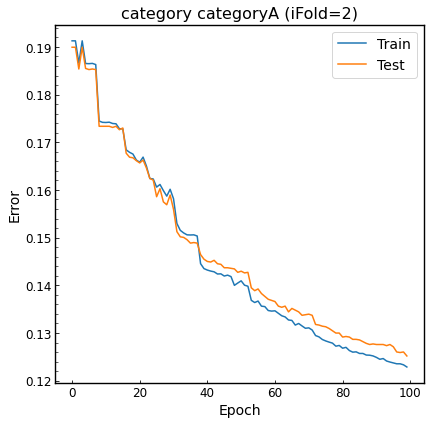

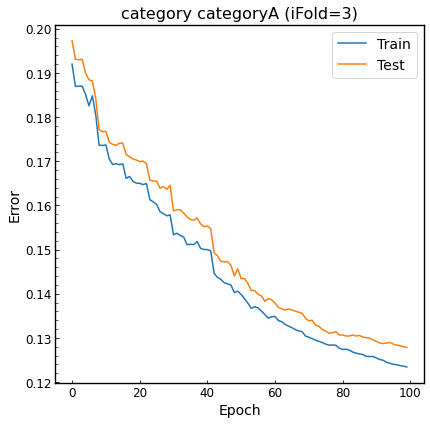

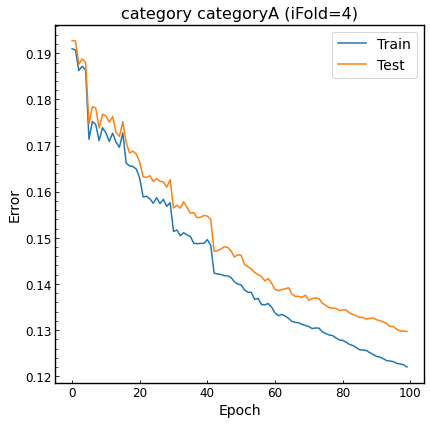

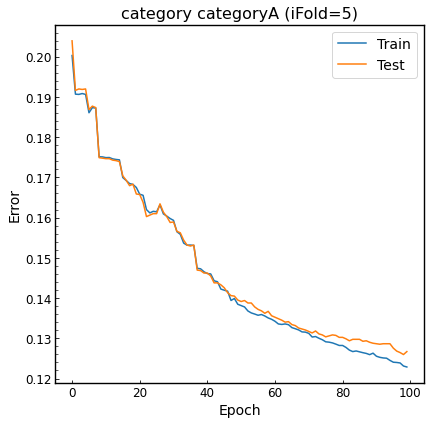

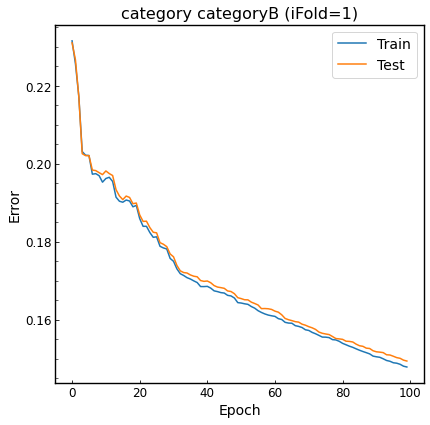

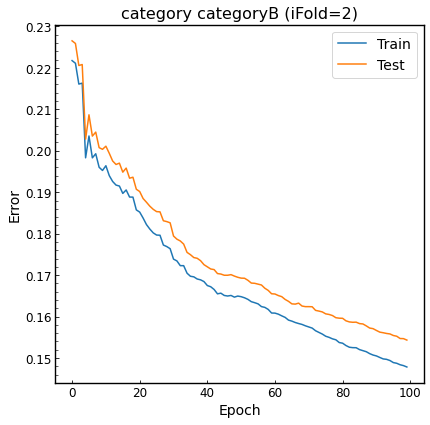

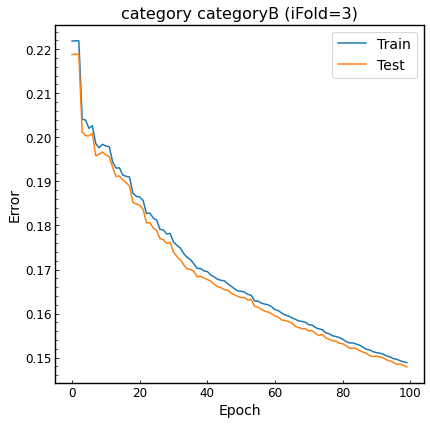

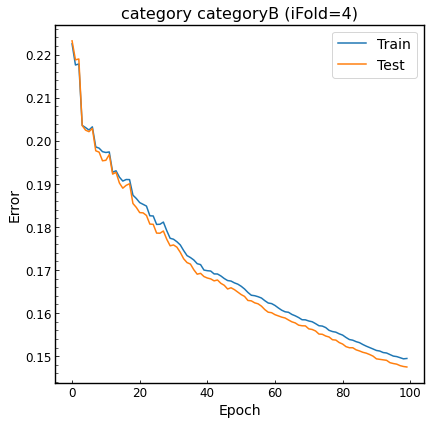

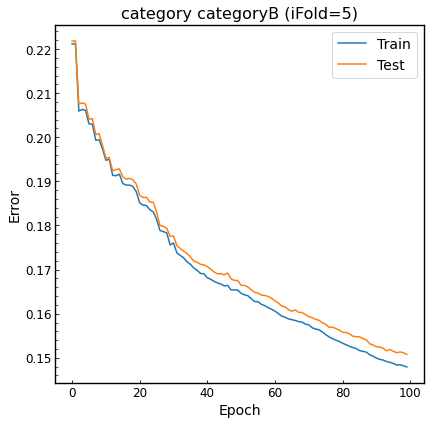

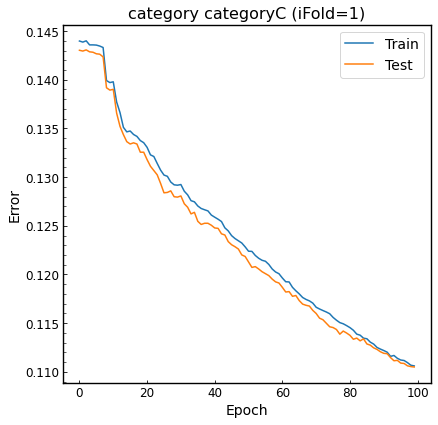

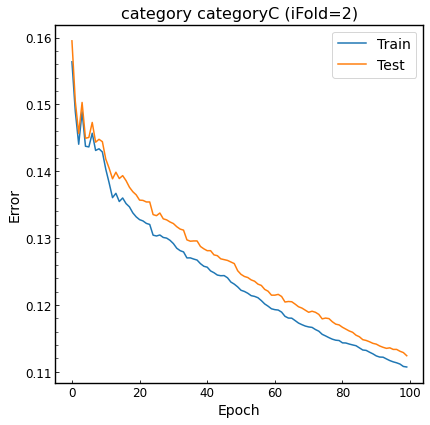

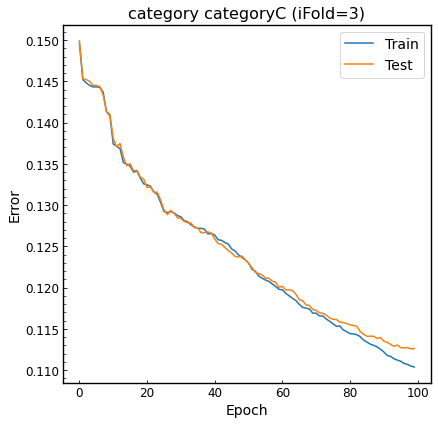

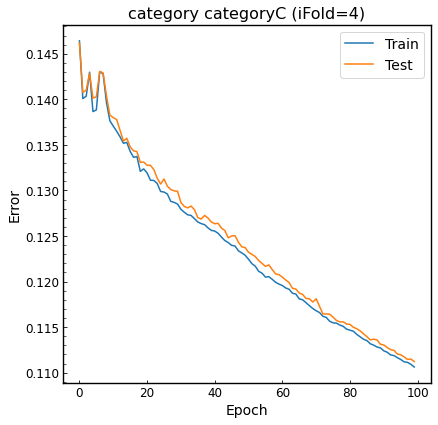

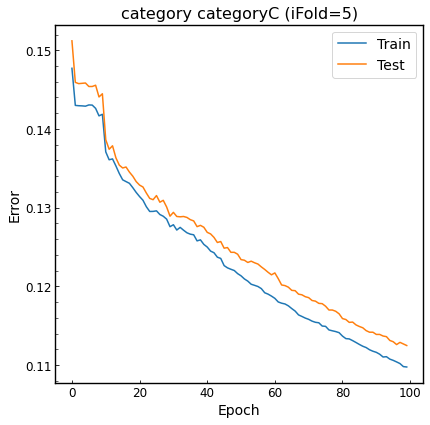

In [51]:
# plot performance 
for category_ in xgbcvclassifiers:
    for fold_ in range(kFolds):
        plot_training_history(xgbcvclassifiers[category_][fold_][0], category_, fold_+1)

In [53]:
bkg_input_X= get_input_features(bkg_tree, training_variables)
ds_input_X= get_input_features(ds_tree, training_variables)
bu_input_X= get_input_features(bu_tree, training_variables)
bd_input_X= get_input_features(bd_tree, training_variables)

In [84]:
bkg_tree = bkg_tree[bkg_tree.columns.drop(list(bkg_tree.filter(regex='xgb')))]

In [82]:
for ic, category_ in enumerate(xgbcvclassifiers):
    for fold_ in range(kFolds):
        #bkg_tree['xgb_{}_fold{}'.format(category_, fold_)] = xgbcvclassifiers[category_][fold_][0].predict(bkg_input_X)
        bkg_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bkg_input_X)
        ds_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(ds_input_X)
        bu_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bu_input_X)
        bd_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bd_input_X)
        if fold_==0 and category_=='categoryA':
            bkg_scores = (bkg_tree['eventNumber']%kFolds==fold_).to_numpy()*(bkg_tree['category']==(ic+1)).to_numpy()*(bkg_tmpscores)
            ds_scores = (ds_tree['eventNumber']%kFolds==fold_).to_numpy()*(ds_tree['category']==(ic+1)).to_numpy()*(ds_tmpscores)
            bu_scores = (bu_tree['eventNumber']%kFolds==fold_).to_numpy()*(bu_tree['category']==(ic+1)).to_numpy()*(bu_tmpscores)
            bd_scores = (bd_tree['eventNumber']%kFolds==fold_).to_numpy()*(bd_tree['category']==(ic+1)).to_numpy()*(bd_tmpscores) 
        else:
            bkg_scores = (bkg_tree['eventNumber']%kFolds==fold_).to_numpy()*(bkg_tree['category']==(ic+1)).to_numpy()*(bkg_tmpscores)
            ds_scores = (ds_tree['eventNumber']%kFolds==fold_).to_numpy()*(ds_tree['category']==(ic+1)).to_numpy()*(ds_tmpscores)
            bu_scores = (bu_tree['eventNumber']%kFolds==fold_).to_numpy()*(bu_tree['category']==(ic+1)).to_numpy()*(bu_tmpscores)
            bd_scores = (bd_tree['eventNumber']%kFolds==fold_).to_numpy()*(bd_tree['category']==(ic+1)).to_numpy()*(bd_tmpscores) 

In [89]:
bkg_tree['bdt'] = bkg_scores
ds_tree['bdt'] = ds_scores
bd_tree['bdt'] = bd_scores
bu_tree['bdt'] = bu_scores

In [91]:
bkg_tree['dataMCType'] = np.ones(len(bkg_scores))*0
ds_tree['dataMCType'] = np.ones(len(ds_scores))*1
bd_tree['dataMCType'] = np.ones(len(bd_scores))*2
bu_tree['dataMCType'] = np.ones(len(bu_scores))*3

In [94]:
# make signal, background t3mmini tree
def get_t3mminitree(df):
    brlist = ['run', 'lumi', 'eventNumber', 'category', 'dataMCType', 'eventWeight', 'var_tauMassRefitted']
    return {key: df[key].values for key in brlist}

In [96]:
t3mminitree = get_t3mminitree(pd.concat([bkg_tree, ds_tree, bd_tree, bu_tree]))

In [99]:
combined_df = pd.concat([bkg_tree, ds_tree, bd_tree, bu_tree])[['run', 'lumi', 'eventNumber', 'category', 'dataMCType', 'eventWeight', 'var_tauMassRefitted']]

In [103]:
combined_df.to_csv('t3mminitree_xgb_maxdepth3_2018UL.csv')

In [ ]:
# fast import
t3mminitree_xgb_maxdepth3_2018UL.csv

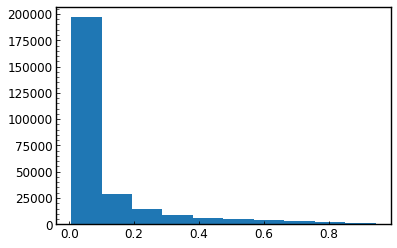

In [73]:
plt.hist(scores[bkg_tree['category']==3])
plt.show()

In [ ]:
param_grid_gb = {
    'gamma': [1, 2, 5, 10], 
    'learning_rate': [0.005, 0.1, 0.3, 0.5],
    'max_depth': [5],
    'n_estimators': [100],
    'reg_alpha': [0, 1, 2, 5, 10, 50],
    'reg_lambda': [1, 2, 5, 10, 50]
}
gb = xgboost.XGBRegressor()
mse_grid = GridSearchCV(estimator = gb, param_grid = param_grid_gb, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
history = mse_grid.fit(X_train, Y_train,
                    eval_set=[(X_train, Y_train), (X_test, Y_test)])

<Figure size 432x288 with 0 Axes>

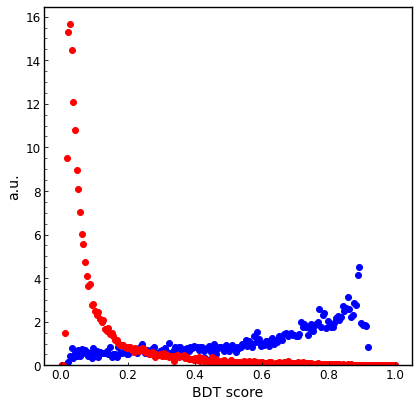

In [321]:
#plt.hist(Y[kfold_split_by_event_categoryA.flatten()==1],
#        histtype='step', color='r', range=(0, 1), bins=50)
test_signal_categoryA = (Y_test==1)
test_bkg_categoryA = (Y_test==0)
plt.clf()
plt.figure(figsize=(6.6,6.6))
hist_ = plt.hist([predictions[test_signal_categoryA], predictions[test_bkg_categoryA]],
                 range=(0, 1), bins=200,
                 color=None, linewidth=0, histtype='step', density=True)
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][0], color='b')
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][1], color='r')
plt.xlabel('BDT score', fontsize=14)
plt.ylabel('a.u.', fontsize=14)
plt.show()

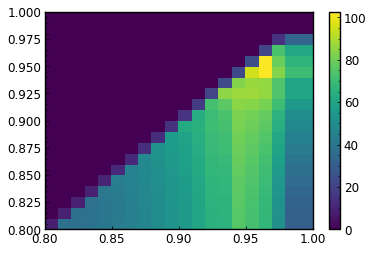

In [320]:
# plot significance as a function of cut-point
S, _heatmap, _grid, _cuts = get_optimal_significance_cuts(hist_)
hbinwidth=0.5*(hist_[1][1]-hist_[1][0])
xarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,0]]
yarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,1]]
plt.hist2d(xarray, yarray, weights=_heatmap, bins=(20, 20), range=((0.8, 1), (0.8, 1)))
plt.colorbar()
plt.xlabel('cut 1')
plt.ylabel('cut 2')
plt.show()

In [297]:
bkg_tree['bdt_categoryC'] = model.predict(get_input_features(bkg_tree, training_variables))
ds_tree['bdt_categoryC'] = model.predict(get_input_features(ds_tree, training_variables))
bu_tree['bdt_categoryC'] = model.predict(get_input_features(bu_tree, training_variables))
bd_tree['bdt_categoryC'] = model.predict(get_input_features(bd_tree, training_variables))

In [300]:
bkg_tree['bdt_categoryC']

0         0.030510
1         0.016624
2         0.055598
3         0.824102
4         0.017992
            ...   
619692    0.061171
619693    0.241288
619694    0.057703
619695    0.019546
619696    0.052224
Name: bdt_categoryC, Length: 619697, dtype: float32

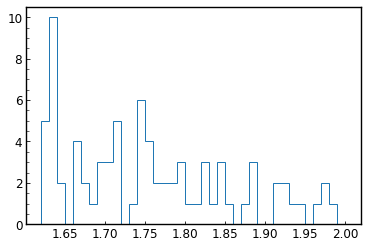

In [80]:
plt.hist(bkg_tree[((bkg_tree['category']==3) &
                (scores>0.92) &
                (scores<0.955))]['var_tauMassRefitted'],
                bins=38, range=(1.62, 2.00), histtype='step')
plt.show()

In [59]:
# prepare a class for xgb trainer

class tau3mu_cv_trainer:
    """
    A class to train, test and evaluate models using xgboost package.
    The train method uses event number to form k-folds and runs k-sets of trainings.
    """
    def __init__(
            config_='test.yml'
            ):
        
        configfile = config_
    
    def load_datasets():
        
        handler = tau3mu_data_handler(self.config)
        handler.load_config_file()
        
    
    def train_model():
        
    
    def load_model():
        
    def get_predictions():
    
    def evaluate_results():
        
    
    def run_hyperspace_optimization():
        
    
    def add_bdt_scores():

        
class tau3mu_data_handler():
    
    def __init__(self):
        
        # read inputfile from config tree
        self.config = None
        
        self.input_file = ''
        #self.output_path = ''
        
        self.categories = OrderedDict()
        self.bdt_cuts = OrderedDict()
        self.bdt_cutb = OrderedDict()
        self.trees = OrderedDict()
        self.input_features = OrderedDict()
        self.spec_features = OrderedDict()
        
        self.event_weights = None
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        return self     
        
    def load_config_file(self):
        
        self.config = ordered_load(open(config_filename), Loader=yaml.SafeLoader)
        print('reading conf. file '+config_filename)
 
        # get the ntuple containing all trees
        if not ('NTUPLE' in self.config):
            print("Specify the input file!")
            return
        
        else:
            if not os.path.exists(self.config['NTUPLE']):
                print("Input file does not exist!")
                return 
        
        self.input_file = self.config['NTUPLE']
        #self.output_path = self.config['OUTPUTFILE']
        
        self.event_weights = self.config['EVENTWEIGHT']
        
        for tree_ in self.config['TREES']:
            self.trees[tree_] = self.config['TREES'][tree_]['NAME']
            self.trees[tree_] = self.config['TREES'][tree_]['TYPE']
            self.trees[tree_] = self.config['TREES'][tree_]['WEIGHT']
        
        for category_ in self.config['MVA']:
            self.bdt_cuts[category_] = self.config['MVA'][category_]['CUTS']
            self.bdt_cutb[category_] = self.config['MVA'][category_]['CUTB']
            self.input_features[category_] = self.config['MVA'][category_]['TRAIN']
            self.spec_features[category_] = self.config['MVA'][category_]['SPEC']
            self.settings[category_] = self.config['MVA'][category_]['SETTING']
        
        self.kfolds = int(self.config['KFOLDS'])
            
    
    def prepare_dataframes(self):
        
        
    
    def prepare_train_datasets(self, category_):
        
        # load data
        
        train_y = []
        train_x = []
        
        input_file = uproot.open(filename)
        varlist = self.input_features[category_]+self.spec_features[category_]+[self.event_weight]
        
        for tree in self.trees:
            cut = ''
            if self.config['TREES'][tree]['TYPE']=='Background':
                cut = self.bdt_cutb[category_]
                train_y
            else: cut = self.bdt_cuts[category_]
            df = get_arrays((input_file[self.config['TREES'][tree_]['NAME']], varlist, cut)
            df['ids'] = df.index.values
            
            train_x.append(get_input_features(df, self.input_features[category_]))
        
        train_x = np.concatenate(tuple(train_x))
        train_y = np.concatenate(tuple(train_y))
        
        return train_x, train_y
    
    def get_arrays(varlist):
        # category A
        
        ds_trainX = get_input_features(ds_tree, varlist, self.bdt_cuts[category_])
        bu_trainX = get_input_features(bu_tree, varlist, self.bdt_cuts[category_])
        bd_trainX = get_input_features(bd_tree, varlist, self.bdt_cuts[category_])

        bkg_eventNumber_categoryA = get_input_features(bkg_tree, ['eventNumber'],
                           'category==0 & var_tauMassRefitted<1.746 & var_tauMassRefitted<1.794')
        ds_eventNumber_categoryA = get_input_features(ds_tree, ['eventNumber'], 'category==0')
        bu_eventNumber_categoryA = get_input_features(bu_tree, ['eventNumber'], 'category==0')
        bd_eventNumber_categoryA = get_input_features(bd_tree, ['eventNumber'], 'category==0')

        kfold_split_by_event_categoryA = np.concatenate((bkg_eventNumber_categoryA % 3,
                                               ds_eventNumber_categoryA % 3,
                                               bu_eventNumber_categoryA % 3,
                                               bd_eventNumber_categoryA % 3))

        bkg_trainY_categoryA = np.zeros(len(bkg_trainX_categoryA))
        ds_trainY_categoryA = np.ones(len(ds_trainX_categoryA))
        bu_trainY_categoryA = np.ones(len(bu_trainX_categoryA))
        bd_trainY_categoryA = np.ones(len(bd_trainX_categoryA))

        bkg_weights_categoryA = np.ones(len(bkg_trainX_categoryA))
        ds_weights_categoryA = ds_trainY_categoryA*0.72
        bu_weights_categoryA = bu_trainY_categoryA*0.14
        bd_weights_categoryA = bd_trainY_categoryA*0.14

        # split data into X and y
        X = np.concatenate((bkg_trainX_categoryA, ds_trainX_categoryA, bu_trainX_categoryA, bd_trainX_categoryA))
        Y = np.concatenate((bkg_trainY_categoryA, ds_trainY_categoryA, bu_trainY_categoryA, bd_trainY_categoryA))
        weight_categoryA = np.concatenate((bkg_weights_categoryA, ds_weights_categoryA, bu_weights_categoryA ,bd_weights_categoryA))
    
    def get_dataset(self, category_):
        
        

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
# plot training history
